In [11]:
import torch 
import sys, os, random
sys.path.append('../../')  # Include parent directory that contains the torchuq package
import torchuq
from torchuq.transform.parametric import TemperatureScaling
from torchuq.metric.categorical import plot_calibration_bin
from torchuq.transform.decision import CalibratorDecision
import numpy as np

In [2]:
# Hyperparameters
num_action = 2
device = torch.device('cuda:%d' % 0)

In [3]:
# Load the pretrained predictions from the densenet model, to reproduce the pretrained predictions use ham_train.ipynb in the pretrained/ folder
reader = torch.load('pretrained/ham10000/densenet161.tar')
predictions = reader['predictions']
labels = reader['labels']
print(predictions.shape, labels.shape)

torch.Size([3005, 7]) torch.Size([3005])


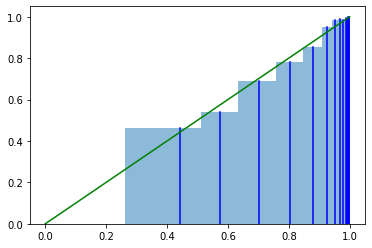

Iteration 0, lr=0.00100, NLL=0.340


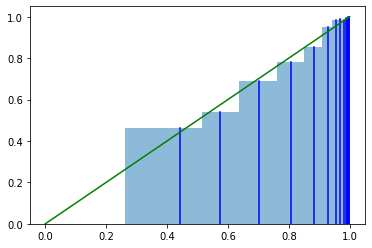

In [4]:
# First use temperature scaling to calibrate the predictions
from torchuq.metric.categorical import plot_calibration_bin
from torchuq.transform.parametric import TemperatureScaling
from matplotlib import pyplot as plt 

plot_calibration_bin(predictions, labels)
plt.show()

ts_calibrator = TemperatureScaling(verbose=True)   # Technically should do a train/test split, but temperature scaling is not going to overfit anyways 
ts_calibrator.train(predictions, labels)
predictions = ts_calibrator(predictions) 
plot_calibration_bin(predictions, labels)
plt.show()

In [5]:
# Randomly split the validation/test set
randperm = np.random.permutation(np.arange(len(predictions)))
predictions = predictions[randperm].to(device)
labels = labels[randperm].to(device)
train_cnt = 1500

In [6]:
# Apply the decision recalibrator
calibrator = CalibratorDecision(verbose=True)
record = calibrator.train(predictions[:train_cnt], labels[:train_cnt], calib_steps=20, num_action=num_action,
                     num_critic_epoch=1000, test_predictions=predictions[train_cnt:], test_labels=labels[train_cnt:])

Step 0, time=21.0, on the val/test set acc=0.879/0.884, avg loss gap=0.0525/0.0398, gap norm=0.0851/0.0631
Step 1, time=42.3, on the val/test set acc=0.887/0.887, avg loss gap=0.0252/0.0282, gap norm=0.0611/0.0494
Step 2, time=63.4, on the val/test set acc=0.890/0.894, avg loss gap=0.0123/0.0156, gap norm=0.0349/0.0276
Step 3, time=84.6, on the val/test set acc=0.893/0.892, avg loss gap=0.0169/0.0212, gap norm=0.0327/0.0272
Step 4, time=105.7, on the val/test set acc=0.901/0.896, avg loss gap=0.0103/0.0148, gap norm=0.0235/0.0198
Step 5, time=127.2, on the val/test set acc=0.901/0.892, avg loss gap=0.0086/0.0131, gap norm=0.0152/0.0183
Step 6, time=148.5, on the val/test set acc=0.904/0.891, avg loss gap=0.0090/0.0145, gap norm=0.0195/0.0156
Step 7, time=169.8, on the val/test set acc=0.905/0.893, avg loss gap=0.0064/0.0119, gap norm=0.0147/0.0138
Step 8, time=191.1, on the val/test set acc=0.905/0.893, avg loss gap=0.0076/0.0138, gap norm=0.0133/0.0165
Step 9, time=207.9, on the val/t

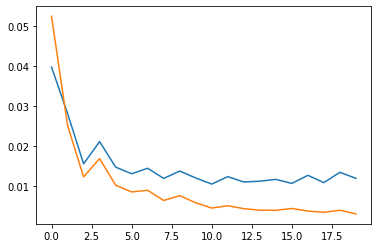

In [10]:
# Plot the performance 
iterations, value = record.get_scalar('gap_max_test')
plt.plot(iterations, value, c='C0')
iterations, value = record.get_scalar('gap_max_train')
plt.plot(iterations, value, c='C1')
plt.show()